In [20]:
from  datetime import datetime, timedelta
import gc
import numpy as np, pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
         "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
        "month": "int16", "year": "int16", "snap_CA": "float32", 'snap_TX': 'float32', 'snap_WI': 'float32' }
PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }

In [3]:
h = 28 
max_lags = 57
tr_last = 1913
fday = datetime(2016,4, 25) 

In [4]:
def create_dt(is_train = True, nrows = None, first_day = 1200):
    
    prices = pd.read_csv("../input/m5-forecasting-accuracy/sell_prices.csv", dtype = PRICE_DTYPES)
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            prices[col] = prices[col].cat.codes.astype("int16")
            prices[col] -= prices[col].min()
            
    cal = pd.read_csv("../input/m5-forecasting-accuracy/calendar.csv", dtype = CAL_DTYPES)
    cal["date"] = pd.to_datetime(cal["date"])
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal[col] = cal[col].cat.codes.astype("int16")
            cal[col] -= cal[col].min()
    
    start_day = max(1 if is_train  else tr_last-max_lags, first_day)
    numcols = [f"d_{day}" for day in range(start_day,tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    dtype = {numcol:"float32" for numcol in numcols} 
    dtype.update({col: "category" for col in catcols if col != "id"})
    dt = pd.read_csv("../input/m5-forecasting-accuracy/sales_train_validation.csv", 
                     nrows = nrows, usecols = catcols + numcols, dtype = dtype)
    
    for col in catcols:
        if col != "id":
            dt[col] = dt[col].cat.codes.astype("int16")
            dt[col] -= dt[col].min()
    
    if not is_train:
        for day in range(tr_last+1, tr_last+ 28 +1):
            dt[f"d_{day}"] = np.nan
    
    dt = pd.melt(dt,
                  id_vars = catcols,
                  value_vars = [col for col in dt.columns if col.startswith("d_")],
                  var_name = "d",
                  value_name = "sales")
    
    dt = dt.merge(cal, on= "d", copy = False)
    dt = dt.merge(prices, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)
    
    return dt

In [5]:
def create_fea(dt):
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]
    for lag, lag_col in zip(lags, lag_cols):
        dt[lag_col] = dt[["id","sales"]].groupby("id")["sales"].shift(lag)

    wins = [7, 28]
    for win in wins :
        for lag,lag_col in zip(lags, lag_cols):
            dt[f"rmean_{lag}_{win}"] = dt[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean())

    date_features = {
        
        "wday": "weekday",
        "week": "weekofyear",
        "month": "month",
        "quarter": "quarter",
        "year": "year",
        "mday": "day",
#         "ime": "is_month_end",
#         "ims": "is_month_start",
    }
#     dt.drop(["d", "wm_yr_wk", "weekday"], axis=1, inplace = True)
    
    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in dt.columns:
            dt[date_feat_name] = dt[date_feat_name].astype("int16")
        else:
            dt[date_feat_name] = getattr(dt["date"].dt, date_feat_func).astype("int16")

In [6]:
FIRST_DAY = 350 # If you want to load all the data set it to '1' -->  Great  memory overflow  risk !
df = create_dt(is_train=True, first_day= FIRST_DAY)

In [7]:
create_fea(df)

In [8]:
df.dropna(inplace = True)
print(df.shape)

(39041269, 31)


In [10]:
cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_name_2", "event_type_1", "event_type_2"]
useless_cols = ["id", "date", "sales","d", "wm_yr_wk", "weekday"]
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df["sales"]

In [11]:
%%time

np.random.seed(777)

fake_valid_inds = np.random.choice(X_train.index.values, 2_000_000, replace = False)
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds)

train_data = lgb.Dataset(X_train.loc[train_inds] , label = y_train.loc[train_inds],  categorical_feature=cat_feats, free_raw_data=False)
fake_valid_data = lgb.Dataset(X_train.loc[fake_valid_inds], label = y_train.loc[fake_valid_inds], categorical_feature=cat_feats, free_raw_data=False)
# This is a random sample, we're not gonna apply any time series train-test-split tricks here!

CPU times: user 16.6 s, sys: 7.52 s, total: 24.1 s
Wall time: 25.8 s


In [17]:
params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.8,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
#         "nthread" : 4
        "metric": ["rmse"],
    'verbosity': 1,
    'num_iterations' : 1200,
    'num_leaves': 128,
    "min_data_in_leaf": 100,
}

In [18]:
m_lgb = lgb.train(params, train_data, valid_sets = [fake_valid_data], verbose_eval=20) 

/usr/local/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	valid_0's rmse: 2.95654
[40]	valid_0's rmse: 2.59891
[60]	valid_0's rmse: 2.5085
[80]	valid_0's rmse: 2.48401
[100]	valid_0's rmse: 2.47146
[120]	valid_0's rmse: 2.4607
[140]	valid_0's rmse: 2.45398
[160]	valid_0's rmse: 2.44701
[180]	valid_0's rmse: 2.44
[200]	valid_0's rmse: 2.43421
[220]	valid_0's rmse: 2.42943
[240]	valid_0's rmse: 2.42568
[260]	valid_0's rmse: 2.42101
[280]	valid_0's rmse: 2.41667
[300]	valid_0's rmse: 2.41108
[320]	valid_0's rmse: 2.40705
[340]	valid_0's rmse: 2.40376
[360]	valid_0's rmse: 2.4007
[380]	valid_0's rmse: 2.39734
[400]	valid_0's rmse: 2.39318
[420]	valid_0's rmse: 2.38941
[440]	valid_0's rmse: 2.38647
[460]	valid_0's rmse: 2.38332
[480]	valid_0's rmse: 2.3801
[500]	valid_0's rmse: 2.37759
[520]	valid_0's rmse: 2.37508
[540]	valid_0's rmse: 2.37286
[560]	valid_0's rmse: 2.37033
[580]	valid_0's rmse: 2.36795
[600]	valid_0's rmse: 2.36529
[620]	valid_0's rmse: 2.36374
[640]	valid_0's rmse: 2.36084
[660]	valid_0's rmse: 2.35985
[680]	valid_0's rmse:

<Figure size 360x720 with 0 Axes>

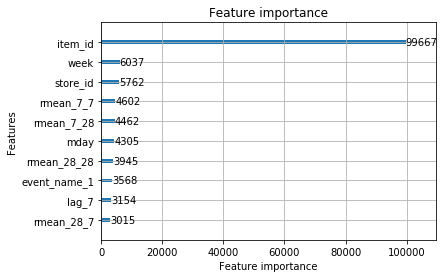

In [22]:
fig = plt.figure(figsize=(5,10))
lgb.plot_importance(m_lgb, max_num_features=10)

In [23]:
%%time

alphas = [1.028, 1.023, 1.018]
weights = [1/len(alphas)]*len(alphas)
sub = 0.

for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

    te = create_dt(False)
    cols = [f"F{i}" for i in range(1,29)]

    for tdelta in range(0, 28):
        day = fday + timedelta(days=tdelta)
        print(tdelta, day)
        tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
        create_fea(tst)
        tst = tst.loc[tst.date == day , train_cols]
        te.loc[te.date == day, "sales"] = alpha*m_lgb.predict(tst) # magic multiplier by kyakovlev



    te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
#     te_sub.loc[te.date >= fday+ timedelta(days=h), "id"] = te_sub.loc[te.date >= fday+timedelta(days=h), "id"].str.replace("validation$", "evaluation")
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
    te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
    te_sub.fillna(0., inplace = True)
    te_sub.sort_values("id", inplace = True)
    te_sub.reset_index(drop=True, inplace = True)
    te_sub.to_csv(f"submission_{icount}.csv",index=False)
    if icount == 0 :
        sub = te_sub
        sub[cols] *= weight
    else:
        sub[cols] += te_sub[cols]*weight
    print(icount, alpha, weight)


sub2 = sub.copy()


0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2016-05-10 00:00:00
16 2016-05-11 00:00:00
17 2016-05-12 00:00:00
18 2016-05-13 00:00:00
19 2016-05-14 00:00:00
20 2016-05-15 00:00:00
21 2016-05-16 00:00:00
22 2016-05-17 00:00:00
23 2016-05-18 00:00:00
24 2016-05-19 00:00:00
25 2016-05-20 00:00:00
26 2016-05-21 00:00:00
27 2016-05-22 00:00:00
0 1.028 0.3333333333333333
0 2016-04-25 00:00:00
1 2016-04-26 00:00:00
2 2016-04-27 00:00:00
3 2016-04-28 00:00:00
4 2016-04-29 00:00:00
5 2016-04-30 00:00:00
6 2016-05-01 00:00:00
7 2016-05-02 00:00:00
8 2016-05-03 00:00:00
9 2016-05-04 00:00:00
10 2016-05-05 00:00:00
11 2016-05-06 00:00:00
12 2016-05-07 00:00:00
13 2016-05-08 00:00:00
14 2016-05-09 00:00:00
15 2

In [ ]:
sub2

In [ ]:
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv("submission.csv",index=False)